In [1]:
import os
import sys
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
from skimage.restoration import denoise_tv_chambolle
import scipy
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
MAX_DENSITY_NB = 25
EXT_WIDTH = 100
WIN_WIDTHS = np.arange(20, 50, 2)

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [4]:
def radius_list(xs:np.ndarray, ys:np.ndarray):
    assert xs.ndim == 1 and ys.ndim == 1
    rad_list = [0.]
    disp_list = []
    for i in range(1, len(xs)):
        rad_list.append(np.sqrt((xs[i] - xs[0])**2 + (ys[i] - ys[0])**2))
        disp_list.append(np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2))
    return np.array(rad_list) / np.mean(disp_list) / len(xs)

In [5]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(win_width//2, len(x_pos) - win_width//2):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[1: int(len(xs)/2)+1] - float(xs[1: int(len(xs)/2)+1][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
            ys1 = ys[1: int(len(ys)/2)+1] - float(ys[1: int(len(ys)/2)+1][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])        

            cum_xs1 = abs(np.cumsum(abs(xs1)))
            cum_xs2 = abs(np.cumsum(abs(xs2)))
            cum_ys1 = abs(np.cumsum(abs(ys1)))
            cum_ys2 = abs(np.cumsum(abs(ys2)))

            xs_max_val = max(np.max(abs(cum_xs1)), np.max(abs(cum_xs2)))
            cum_xs1 = cum_xs1 / xs_max_val
            cum_xs2 = cum_xs2 / xs_max_val

            ys_max_val = max(np.max(abs(cum_ys1)), np.max(abs(cum_ys2)))
            cum_ys1 = cum_ys1 / ys_max_val
            cum_ys2 = cum_ys2 / ys_max_val
            
            vals.append((abs(cum_xs1[-1] - cum_xs2[-1] + cum_ys1[-1] - cum_ys2[-1]))
                        + (max(np.std(xs1), np.std(xs2)) - min(np.std(xs1), np.std(xs2)))
                        + (max(np.std(ys1), np.std(ys2)) - min(np.std(ys1), np.std(ys2))))
                    
        vals = np.concatenate((np.ones(int(win_width/2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)

    all_vals = np.array(all_vals) + 1e-5
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [6]:
def slice_data(signal_seq, jump_d, ext_width, shift_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - shift_width//2: i + shift_width//2]
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [7]:
def climb_mountain(signal, cp, seuil=5):
    while True:
        vals = [signal[x] if 0<=x<signal.shape[0] else -1 for x in range(cp-seuil,cp+1+seuil)]
        if len(vals) == 0:
            return -1
        new_cp = cp + np.argmax(vals) - seuil
        if new_cp == cp:
            return new_cp
        else:
            cp = new_cp

In [8]:
def position_extension(x, y, ext_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])[1:]
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])[1:]
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)
    return np.array(datas), delta_prev_data.shape[0], delta_next_data.shape[0]

In [9]:
def sigmoid(x, beta=3):
    x = np.minimum(np.ones_like(x)*0.999, x)
    x = np.maximum(np.ones_like(x)*0.001, x)
    return 1 / (1 + (x / (1-x))**(-beta))

In [10]:
def density_estimation(x, y, ext1, ext2, max_nb):
    densities = []
    dist_amp = 2.0
    local_mean_window_size = 5
    
    for i in range(x.shape[0]):
        density1 = 0
        density2 = 0
        
        slice_x = x[max(0, i-max_nb//2):i].copy()
        slice_y = y[max(0, i-max_nb//2):i].copy()
        
        if len(slice_x) > 0:
            mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x)//2]
            slice_y -= slice_y[len(slice_y)//2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                    density1 += 1
    
        slice_x = x[i:min(x.shape[0], i+max_nb//2)].copy()
        slice_y = y[i:min(x.shape[0], i+max_nb//2)].copy()
                
        if len(slice_x) > 0:
            mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x)//2]
            slice_y -= slice_y[len(slice_y)//2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                    density2 += 1
        densities.append(max(density1, density2))
        
    
    # local_mean
    new_densities = []
    for i in range(len(densities)):
        new_densities.append(np.mean(densities[max(0, i-local_mean_window_size//2): 
                                               min(len(densities), i+local_mean_window_size//2+1)]))
    densities = new_densities
        
    return np.array(densities)

In [11]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d, shift_width):
    assert ext_width > shift_width
    datas, shape_ext1, shape_ext2 = position_extension(x, y, ext_width)
    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)

    density = density_estimation(datas[0], datas[1], 
                                 shape_ext1, shape_ext2, 
                                 max_nb=MAX_DENSITY_NB*2)

    denoised_den = denoise_tv_chambolle(density, weight=3, eps=0.0002, max_num_iter=100, channel_axis=None)
    denoised_den = sigmoid(denoised_den / MAX_DENSITY_NB)
    #denoised_den = 1
    
    signal = signal[:,] * denoised_den
    sliced_signals, slice_indice = slice_data(signal, jump_d, shape_ext1, shift_width)
    
    return (signal[:, shape_ext1:signal.shape[1] - shape_ext2],
            sliced_signals,
            slice_indice,
            signal,
            denoised_den,
            shape_ext1, shape_ext2)

In [12]:
def local_roughness(signal, window_size):
    uc_signal = uncumulate(signal)
    uc_signal /= abs(uc_signal)
    counts = []
    for i in range(window_size//2, len(uc_signal) - window_size//2):
        count = 0
        cur_state = 1
        for j in range(i-window_size//2, i+window_size//2):
            new_state = uc_signal[j]
            if new_state != cur_state:
                count += 1
            cur_state = new_state
        counts.append(count)
    counts = np.concatenate(([counts[0]] * (window_size//2), counts))
    counts = np.concatenate((counts, [counts[-1]] * (window_size//2)))
    return counts

In [13]:
def slice_normalize(slices):
    val = np.mean(np.sum(slices, axis=(2)).T, axis=0)
    val = val - np.min(val)
    val = val / np.max(val)
    return val

In [14]:
def displacements(x, y):
    disps = []
    for i in range(len(x) - 1):
        x_seg = x[i + 1] - x[i]
        y_seg = y[i + 1] - y[i]
        disp = np.sqrt(x_seg ** 2 + y_seg ** 2)
        disps.append([np.log10(disp)])
    return np.array(disps).mean()

In [25]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
track = 2
exp = 0
fovs = [0]
traj_idx = [15] # 0exp0fov of 3, 11, 13, 15, 16, 38, 46 check,, exp10,fov0,idx7 check
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
changepoints = []

In [42]:
trajs_model, labels_model = models_phenom().single_state(N=2,
                                                        L=None,
                                                        T=128,
                                                        alphas=1.0,
                                                        Ds=2,
                                                       )
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]

disp_list = np.array([displacements(x, y)])
print(disp_list.shape)
try:
    print(10**reg_k_model.predict(disp_list), reg_k_model.predict(disp_list))
except Exception as e:
    print(e)

(1,)
1/1 [==============================] - 0s 13ms/step
[[1.9457408]] [[0.289085]]


In [230]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=None,
                                                        T=200,
                                                        alphas=[0.1, 1.0],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]

GT: [], Length:190
sig_mean: 0.2599027253744719


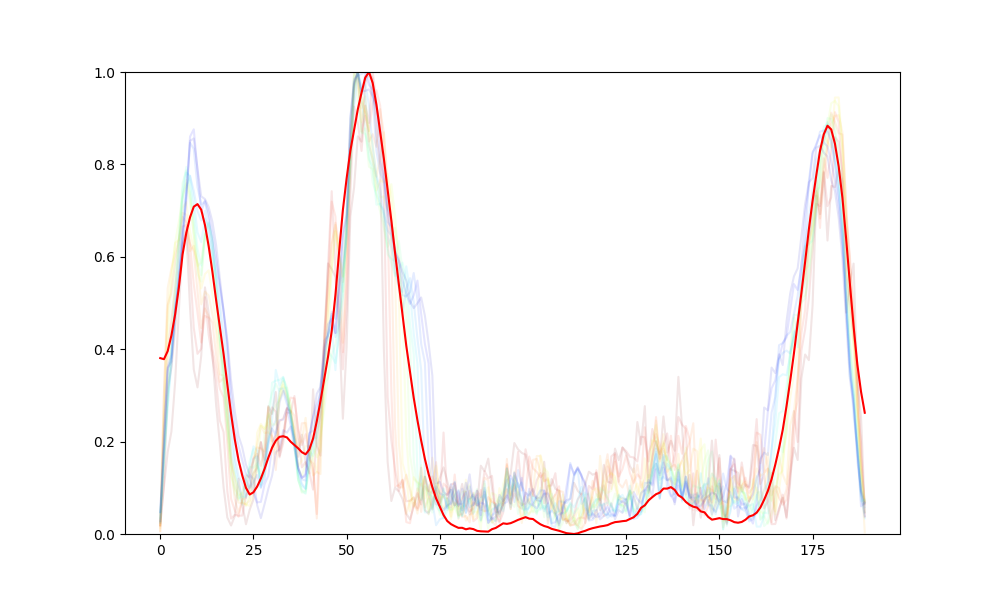

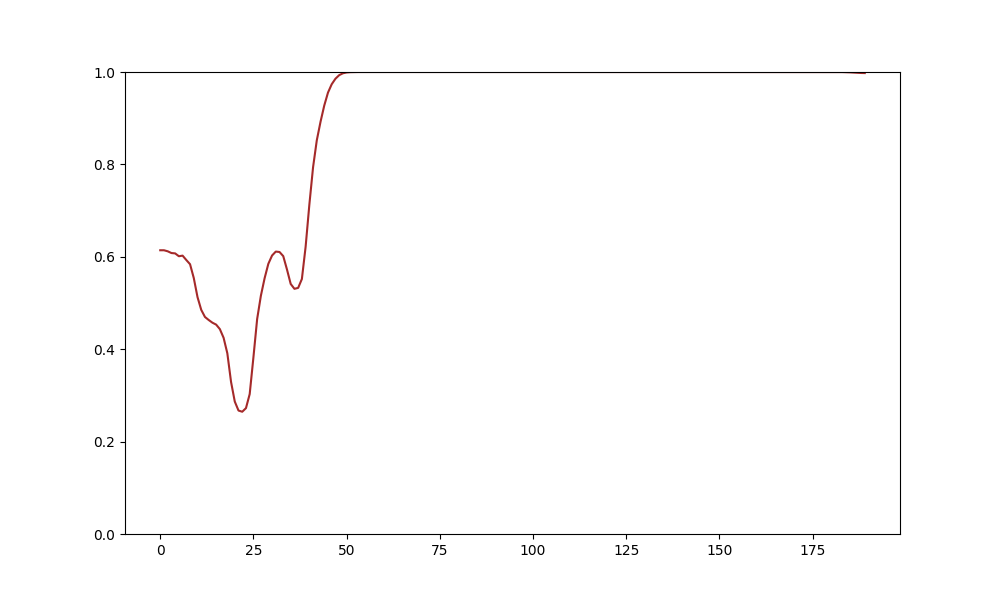

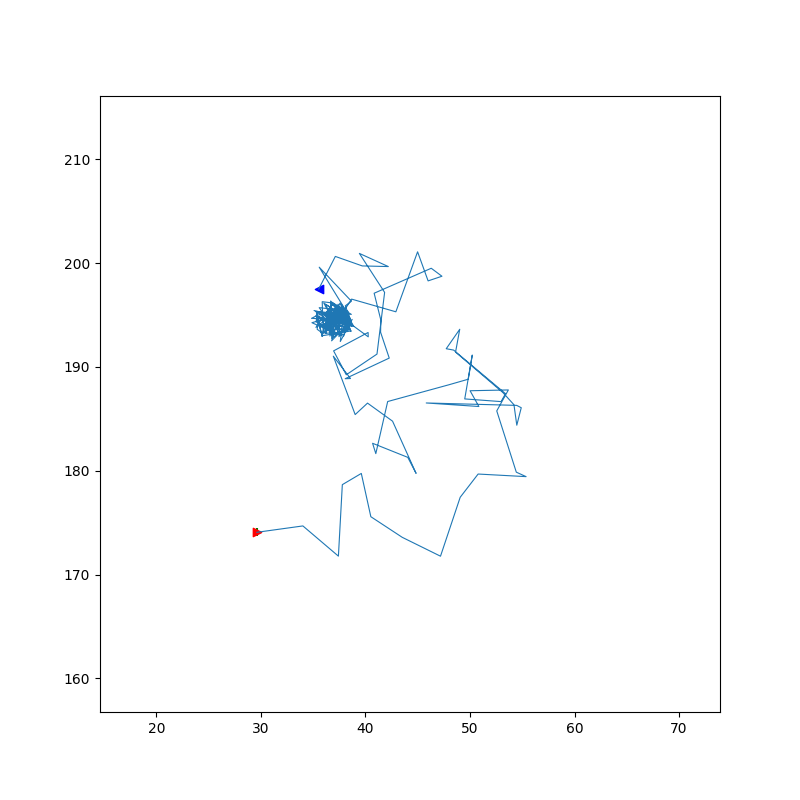

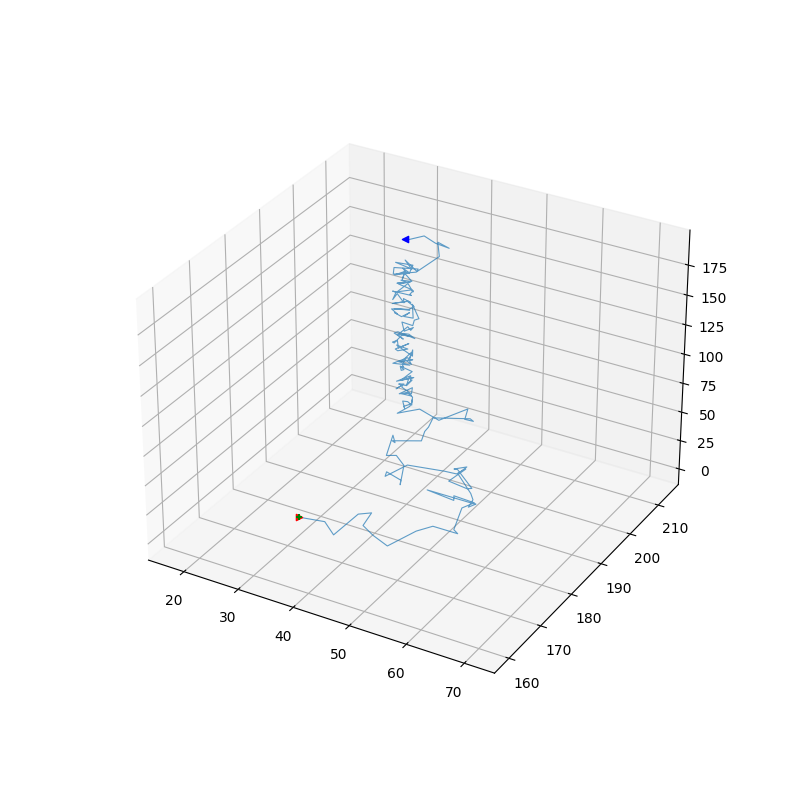

In [26]:
print(f'GT: {changepoints}, Length:{x.shape[0]}')
checkpoints = [0]

signals, sliced_signals, _, _, denoised_density, l_ext,_ = signal_from_extended_data(x, y,
                                                                            WIN_WIDTHS,
                                                                            EXT_WIDTH,
                                                                            1,
                                                                            10)
slice_norm_signal = slice_normalize(sliced_signals)
print(f'sig_mean: {np.mean(slice_norm_signal)}')

plt.figure(figsize=(10, 6))
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i] / np.max(signals[i]), alpha=0.1,
             c=color_seq[int(i * 255 / signals.shape[0])])
plt.plot(np.arange(signals.shape[1]), slice_norm_signal, c='red')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
plt.ylim([0, 1])

if not isinstance(denoised_density, int):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(signals.shape[1]), denoised_density[l_ext:l_ext + signals.shape[1]], c='brown')
    for cp in changepoints:
        plt.vlines(cp, 0, 1, color='blue')
    plt.ylim([0, 1])

#############################################################################

plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
for checkpoint in checkpoints:
    plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
plt.xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in changepoints:
    plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.set_ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)
for checkpoint in checkpoints:
    ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

In [ ]:
def signal_comparison(x_pos, y_pos, win_widths, ext_width, checkpoint1, checkpoint2, *args):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        xs1 = x_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        ys1 = y_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        
        xs2 = x_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        ys2 = y_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        
        xs1_l = xs1[1: int(len(xs1)/2)+1] - float(xs1[1: int(len(xs1)/2)+1][0])
        xs1_r = xs1[int(len(xs1)/2):] - float(xs1[int(len(xs1)/2):][0])

        ys1_l = ys1[1: int(len(ys1)/2)+1] - float(ys1[1: int(len(ys1)/2)+1][0])
        ys1_r = ys1[int(len(ys1)/2):] - float(ys1[int(len(ys1)/2):][0])
        
        xs2_l = xs2[1: int(len(xs2)/2)+1] - float(xs2[1: int(len(xs2)/2)+1][0])
        xs2_r = xs2[int(len(xs2)/2):] - float(xs2[int(len(xs2)/2):][0])

        ys2_l = ys2[1: int(len(ys2)/2)+1] - float(ys2[1: int(len(ys2)/2)+1][0])
        ys2_r = ys2[int(len(ys2)/2):] - float(ys2[int(len(ys2)/2):][0])
        
        std_xs1_l = np.std(xs1_l)
        std_xs1_r = np.std(xs1_r)
        std_ys1_l = np.std(ys1_l)
        std_ys1_r = np.std(ys1_r)
        std_xs2_l = np.std(xs2_l)
        std_xs2_r = np.std(xs2_r)
        std_ys2_l = np.std(ys2_l)
        std_ys2_r = np.std(ys2_r)
        
        xs1_l = np.cumsum(abs(xs1_l))
        xs1_r = np.cumsum(abs(xs1_r))
        ys1_l = np.cumsum(abs(ys1_l))
        ys1_r = np.cumsum(abs(ys1_r))
        xs2_l = np.cumsum(abs(xs2_l))
        xs2_r = np.cumsum(abs(xs2_r))
        ys2_l = np.cumsum(abs(ys2_l))
        ys2_r = np.cumsum(abs(ys2_r))

        #xs1_l, xs1_r, ys1_l, ys1_r
        #xs2_l, xs2_r, ys2_l, ys2_r
        comb = [[[xs1_l, xs2_r], [ys1_l, ys2_r]], [[xs1_r, xs2_r], [ys1_r, ys2_r]],
               [[xs1_l, xs2_l], [ys1_l, ys2_l]], [[xs1_r, xs2_l], [ys1_r, ys2_l]]]
        comb2 = [[std_xs1_l, std_xs2_r, std_ys1_l, std_ys2_r], [std_xs1_r, std_xs2_r, std_ys1_r, std_ys2_r],
                 [std_xs1_l, std_xs2_l, std_ys1_l, std_ys2_l], [std_xs1_r, std_xs2_l, std_ys1_r, std_ys2_l]]
                 
        for cb, cb2 in zip(comb, comb2):
            tmp_vals = []
            for s in cb:
                l, r = s[0], s[1]
                max_val = max(np.max(abs(l)), np.max(abs(r)))
                l_val = l / max_val
                r_val = r / max_val
                tmp_vals.append(l_val)
                tmp_vals.append(r_val)
            val = abs(tmp_vals[0][-1] - tmp_vals[1][-1] + tmp_vals[2][-1] - tmp_vals[3][-1])
                       #+ (max(cb2[0], cb2[1]) - min(cb2[0], cb2[1]))
                       #+ (max(cb2[2], cb2[3]) - min(cb2[2], cb2[3])))
            vals.append(val)
        vals = np.array(vals)
        all_vals.append(vals)
    all_vals = np.array(all_vals)
    mean_vals = np.sort(all_vals.T, axis=1)[:, int(len(win_widths) * 0.25): int(len(win_widths) * 0.75)].mean(axis=1)
    
    if checkpoint1 in args:
        print(checkpoint1, checkpoint2, mean_vals, win_widths[np.argmax(all_vals, axis=0)[0]])
        print(all_vals)
        
    if (mean_vals[1] + mean_vals[2]) / 2 >= 1 and (mean_vals[0] + mean_vals[3]) / 2 < 1 and mean_vals[1] > 1 and mean_vals[2] > 1:
        return 1
    elif (mean_vals[1] + mean_vals[2]) / 2 < 1. and (mean_vals[0] + mean_vals[3]) / 2 >= 1 and mean_vals[0] > 1 and mean_vals[3] > 1:
        return -1
    else:
        return 0

In [ ]:
def check_pts_mat(checkpoints, x, y, win_widths, ext_width, *args):
    cp_mat = np.zeros((len(checkpoints), len(checkpoints))).astype(int) - 1
    datas, k, kk = position_extension(x, y, ext_width)
    print(k, kk, ext_width)
    for i in range(cp_mat.shape[0]):
        for j in range(cp_mat.shape[1]):
            gap = abs(checkpoints[i] - checkpoints[j]) * 2
            gap = min(gap, 100)
            if i == j:
                gap = 80
            local_win_widths = np.arange(max(10, gap-20), gap+20, 2)
            cp_mat[i][j] = signal_comparison(datas[0], datas[1],
                                             local_win_widths, k,
                                             checkpoints[i], checkpoints[j], args)
    
    return cp_mat

In [ ]:
print(f'GT: {changepoints}')

xa = []
for det_cp in np.where(slice_norm_signal > 0.25)[0]:
    xa.append(climb_mountain(slice_norm_signal, det_cp, seuil=5))
xa = np.unique(xa)

print(xa)
print(xa[np.argsort(slice_norm_signal[xa])[::-1]])
check_arange = np.arange(50, 100, 2) #WIN_WIDTHS

In [ ]:
cor_mat = check_pts_mat(xa, x, y,
                        check_arange, EXT_WIDTH, [56])
print(cor_mat)
plt.figure(figsize = (11,8))
sns.heatmap(cor_mat, xticklabels=xa, yticklabels=xa)
plt.show()

In [15]:
def model_selection(length):
    reg_model_num = -1
    seuil = -1
    if length < 8:
        reg_model_num = 5
        seuil = 0.60
        
    elif length < 12:
        reg_model_num = 8
        seuil = 0.50

    elif length < 16:
        reg_model_num = 12
        seuil = 0.35

    elif length < 32:
        reg_model_num = 16
        seuil = 0.30

    elif length < 48:
        reg_model_num = 32
        seuil = 0.25

    elif length < 64:
        reg_model_num = 48
        seuil = 0.20

    elif length < 128:
        reg_model_num = 64
        seuil = 0.15

    elif length < 144:
        reg_model_num = 128
        seuil = 0.10

    else:
        reg_model_num = 144
        seuil = 0.10

    return reg_model_num, seuil

In [16]:
def cvt_2_signal(x, y):
    rad_list = radius_list(x, y)
    x = x / (np.std(x))
    x = np.cumsum(abs(uncumulate(x))) / len(x)
    y = y / (np.std(y))
    y = np.cumsum(abs(uncumulate(y))) / len(y)
    return np.vstack((x, rad_list)).T, np.vstack((y, rad_list)).T

In [17]:
def partition_trajectory(x, y, cps):
    if len(cps) == 0:
        return [x], [y]
    new_x = []
    new_y = []
    for i in range(1, len(cps)):
        new_x.append(x[cps[i-1]:cps[i]].copy())
        new_y.append(y[cps[i-1]:cps[i]].copy())
    return new_x, new_y

In [18]:
reg_model_nums = [5, 8, 12, 16, 32, 48, 64, 128, 144]
reg_models = {n:tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{n}.keras') for n in reg_model_nums}
reg_k_model = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_k_model.keras')

2024-06-13 11:21:34.257277: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-13 11:21:34.257318: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-13 11:21:34.257324: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-13 11:21:34.257356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 11:21:34.257371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### TEST

In [19]:
def sort_by_signal(signal, cps):
    sort_indice = np.argsort(signal[cps])
    indice_tuple = [(i, i+1) for i in sort_indice]
    return indice_tuple, sort_indice

In [20]:
def recoupe_trajectory(x, y, model_num, jump=1):
    couped_x = []
    couped_y = []
    for i in range(0, len(x), jump):
        tmp1 = x[i: i+model_num]
        tmp2 = y[i: i+model_num]
        if len(tmp1) == model_num:
            couped_x.append(tmp1)
            couped_y.append(tmp2)
    return np.array(couped_x), np.array(couped_y)

In [21]:
def exhaustive_cps_search(x, y, win_widths, ext_width, search_seuil=0.20, cluster=None):
    if len(x) < np.min(reg_model_nums):
        return np.array([0, len(x)]), np.array([1.0]), np.array([0.1]), np.array([len(x)])
    
    if cluster is not None and len(cluster.means_) == 1:
        start_cps = []
        slice_norm_signal = np.zeros_like(x.shape)
    else:
        if len(x) + 2*(len(x)-1) >= win_widths[0]:
            signals, sliced_signals, _, _, denoised_density, l_ext,_ = signal_from_extended_data(x, y,
                                                                                        win_widths,
                                                                                        ext_width,
                                                                                        1,
                                                                                        10)
            slice_norm_signal = slice_normalize(sliced_signals)

            det_cps = []
            for det_cp in np.where(slice_norm_signal > search_seuil)[0]:
                det_cps.append(climb_mountain(slice_norm_signal, det_cp, seuil=5))
            det_cps = np.unique(det_cps)
            start_cps = list(det_cps.copy())
        else:
            start_cps = []
            slice_norm_signal = np.zeros_like(x.shape)

    start_cps.append(0)
    start_cps.append(len(x))
    start_cps = np.sort(start_cps)
    cps_copy = [0]
    for i in range(1, len(start_cps)-1):
        if start_cps[i] - start_cps[i-1] > 5 and start_cps[i+1] - start_cps[i] > 5:
            cps_copy.append(start_cps[i])
    start_cps = cps_copy
    start_cps.append(len(x))
    
    while True:
        filtered_cps = []
        alpha_preds = []
        seuil_preds = []
        k_preds = []
        
        part_xs, part_ys = partition_trajectory(x, y, start_cps)
        for p_x, p_y in zip(part_xs, part_ys):
            input_signals = []
            disp = []
            
            model_num, seuil = model_selection(len(p_x))
            model = reg_models[model_num]

            re_couped_x, re_couped_y = recoupe_trajectory(p_x, p_y, model_num)
            for r_x, r_y in zip(re_couped_x, re_couped_y):
                input_signal1, input_signal2 = cvt_2_signal(r_x, r_y)
                input_signals.append(input_signal1)
                input_signals.append(input_signal2)

            input_signals = np.array(input_signals).reshape(-1, model_num, 1, 2)
            pred_alpha = model.predict(input_signals, verbose=0).flatten()

            if len(pred_alpha) > 4:
                pred_alpha = np.sort(pred_alpha)[int(0.25 * len(pred_alpha)): int(0.75 * len(pred_alpha))].mean()
            else:
                pred_alpha = np.mean(pred_alpha)
                
            k_preds.append(reg_k_model.predict(np.array([displacements(p_x, p_y)]), verbose=0)[0][0])
            alpha_preds.append(pred_alpha)
            seuil_preds.append(seuil)
            
        delete_cps = -1
        if cluster is not None:
            sorted_indice_tuple, sorted_indice = sort_by_signal(slice_norm_signal, start_cps[1:-1])
            for (l, r), i in zip(sorted_indice_tuple, sorted_indice):
                i += 1
                diff_alpha = abs(alpha_preds[l] - alpha_preds[r])
                diff_seuil = (seuil_preds[l] + seuil_preds[r])

                cluster_pred_label = cluster.predict([[alpha_preds[l], k_preds[l]], [alpha_preds[r], k_preds[r]]])
                cluster_pred_proba = cluster.predict_proba([[alpha_preds[l], k_preds[l]], [alpha_preds[r], k_preds[r]]])

                prev_cluster_pred_label = cluster_pred_label[0]
                after_cluster_pred_label = cluster_pred_label[1]
                prev_cluster_pred_probas = cluster_pred_proba[0]
                after_cluster_pred_probas = cluster_pred_proba[1]

                left_length = start_cps[i] - start_cps[i-1]
                right_length = start_cps[i+1] - start_cps[i]
                
                """
                cluster_means = cluster.means_
                prev_mean = cluster_means[prev_cluster_pred_label]
                max_dist_mean = []
                for cur_mean in cluster_means:
                    max_dist_mean.append((prev_mean[0] - cur_mean[0])**2 + (prev_mean[1] - cur_mean[1])**2)
                target_label = np.argmax(max_dist_mean)
                """

                if right_length < 32 or left_length < 32:
                    if after_cluster_pred_probas[prev_cluster_pred_label] > 0.001 or prev_cluster_pred_probas[after_cluster_pred_label] > 0.001:
                        delete_cps = start_cps[i]
                elif right_length < 64 or left_length < 64:
                    if after_cluster_pred_probas[prev_cluster_pred_label] > 0.02 or prev_cluster_pred_probas[after_cluster_pred_label] > 0.02:
                        delete_cps = start_cps[i]    
                else:
                    if after_cluster_pred_probas[prev_cluster_pred_label] > 0.05 or prev_cluster_pred_probas[after_cluster_pred_label] > 0.05:
                        delete_cps = start_cps[i]    

        if delete_cps == -1:
            filtered_cps = start_cps
            break
        else:
            start_cps.remove(delete_cps)

    seg_lengths = uncumulate(np.array(filtered_cps))[1:]
    
    alpha_preds = np.array(alpha_preds)
    filtered_cps = np.array(filtered_cps)
    k_preds = np.array(k_preds)
    return filtered_cps, alpha_preds, k_preds, seg_lengths

In [24]:
print(f'GT: {changepoints}')
detected_points = exhaustive_cps_search(x, y, WIN_WIDTHS, EXT_WIDTH, 0.25, cluster=cluster)
print(detected_points)

input_signals=[]
re_couped_x, re_couped_y = recoupe_trajectory(x, y, model_selection(len(x))[0])
for r_x, r_y in zip(re_couped_x, re_couped_y):
    input_signal1, input_signal2 = cvt_2_signal(r_x, r_y)
    input_signals.append(input_signal1)
    input_signals.append(input_signal2)
input_signals = np.array(input_signals).reshape(-1, model_selection(len(x))[0], 1, 2)
pred_alpha = np.mean(reg_models[model_selection(len(x))[0]].predict(input_signals, verbose=0).flatten())
print(pred_alpha)

NameError: name 'changepoints' is not defined

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
for dtp in detected_points[0][1:-1]:
    plt.scatter(x[dtp], y[dtp], marker='+', c='green')
plt.xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in changepoints:
    plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 15,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.set_ylim([np.min(y) - 15,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 15])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)
for dtp in detected_points[0]:
    ax.scatter3D(x[dtp], y[dtp], np.arange(signals.shape[1])[dtp], marker='+', c='green')

# Produce results

In [22]:
def gauss2d(x, mu_x, mu_y, sigma_x, sigma_y, norm_factor):
    return norm_factor * np.exp(-1/2 * (((x[0] - mu_x)/sigma_x)**2 + ((x[1] - mu_y)/sigma_y)**2))

In [23]:
def gauss1d(x, mu, fixed_sigma, norm_fac):
    #fixed_sigma = 1.0
    return norm_fac * np.exp((-1/2) * ((x - mu) / fixed_sigma) ** 2)

In [23]:
public_data_path = f'public_data_validation_v1/' # make sure the folder has this name or change it
submit_number = 6
path_results = f'result_validation_{submit_number}/'
if not os.path.exists(path_results):
    os.makedirs(path_results)

N_EXP = 13
N_FOVS = 30

In [24]:
for track in [1, 2]:
    
    # Create the folder of the track if it does not exists
    path_track = path_results + f'track_{track}/'
    if not os.path.exists(path_track):
        os.makedirs(path_track)
        
    for exp in range(N_EXP):
        # Create the folder of the experiment if it does not exits
        path_exp = path_track+f'exp_{exp}/'
        if not os.path.exists(path_exp):
            os.makedirs(path_exp)
        """
        file_name = path_exp + 'ensemble_labels.txt'
        
        with open(file_name, 'a') as f:
            # Save the model (random) and the number of states (2 in this case)
            model_name = np.random.choice(datasets_phenom().avail_models_name, size = 1)[0]
            f.write(f'model: {model_name}; num_state: {2} \n')

            # Create some dummy data for 2 states. This means 2 columns
            # and 5 rows
            data = np.random.rand(5, 2)
            
            data[-1,:] /= data[-1,:].sum()

            # Save the data in the corresponding ensemble file
            np.savetxt(f, data, delimiter = ';')
        """

In [ ]:
# Define the number of experiments and number of FOVS
print(f'Submit number: {submit_number}')
for track in [2, 1]:
    path_track = path_results + f'track_{track}/'

    for exp in range(N_EXP):
        path_exp = path_track + f'exp_{exp}/'
        print(f'Track: {track}, Exp: {exp}')
        try:
            loaded = np.load(f'{path_results}/priors_{track}_{exp}.npz')
            all_alphas = loaded['alphas']
            all_seg_lengths = loaded['seg_lengths']
            all_ks = loaded['all_ks']
            no_priors = False
        except:
            no_priors = True

        if no_priors:
            all_seg_lengths = []
            all_alphas = []
            all_ks = []
            
            for fov in range(N_FOVS):
                # We read the corresponding csv file from the public data and extract the indices of the trajectories:
                if track == 2:
                    df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
                else:
                    df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
                traj_idx = np.sort(df.traj_idx.unique())

                # Loop over each index
                for idx in traj_idx:
                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]
                
                    cps, alphas, ks, seg_lengths = exhaustive_cps_search(x, y,
                                                                         WIN_WIDTHS,
                                                                         EXT_WIDTH,
                                                                         search_seuil=0.20)
                    all_alphas.extend(alphas)
                    all_seg_lengths.extend(seg_lengths)
                    all_ks.extend(ks)

            all_alphas = np.array(all_alphas)
            all_seg_lengths = np.array(all_seg_lengths)
            all_ks = np.array(all_ks)
            np.savez(f'{path_results}/priors_{track}_{exp}.npz', alphas=all_alphas, seg_lengths=all_seg_lengths, all_ks=all_ks)

Submit number: 6
Track: 2, Exp: 0


2024-06-13 11:22:40.020866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Track: 2, Exp: 1
Track: 2, Exp: 2
Track: 2, Exp: 3
Track: 2, Exp: 4
Track: 2, Exp: 5
Track: 2, Exp: 6
Track: 2, Exp: 7
Track: 2, Exp: 8
Track: 2, Exp: 9
Track: 2, Exp: 10
Track: 2, Exp: 11
Track: 2, Exp: 12
Track: 1, Exp: 0
Track: 1, Exp: 1
Track: 1, Exp: 2
Track: 1, Exp: 3
Track: 1, Exp: 4
Track: 1, Exp: 5
Track: 1, Exp: 6
Track: 1, Exp: 7
Track: 1, Exp: 8
Track: 1, Exp: 9
Track: 1, Exp: 10
Track: 1, Exp: 11
Track: 1, Exp: 12


In [24]:
# Define the number of experiments and number of FOVS
print(f'Submit number: {submit_number}')
for track in [2]:
    path_track = path_results + f'track_{track}/'

    for exp in range(N_EXP):
        path_exp = path_track + f'exp_{exp}/'
        print(f'Track: {track}, Exp: {exp}')
        try:
            #loaded = np.load(f'{path_results}/old_priors_0.20_seuil/old_priors_{track}_{exp}.npz')
            loaded = np.load(f'{path_results}/priors_{track}_{exp}.npz')
            all_alphas = loaded['alphas']
            all_seg_lengths = loaded['seg_lengths']
            all_ks = loaded['all_ks'].flatten()
            no_priors = False
        except:
            no_priors = True
            print(f'No priors for exp:{exp}')
            
        print('--- post processing ---')
        alpha_range = np.linspace(-2.2, 4.2, 300)
        k_range = np.linspace(-6.2, 6.2, 600)
        all_alphas = all_alphas[np.argwhere((all_seg_lengths > 48) & (all_seg_lengths < 256)).flatten()]
        all_ks = all_ks[np.argwhere((all_seg_lengths > 48) & (all_seg_lengths < 256)).flatten()]

        H, xedges, yedges = np.histogram2d(all_alphas, all_ks, bins=[alpha_range, k_range])
        H = H / np.sum(H)


        poten_nb_states = 0
        means = []
        covs = []
        weights = []
        for data, data_range in zip([all_alphas, all_ks], [alpha_range, k_range]):
            nb_states = 0
            weight_sum = 0
            mean_tmp = []
            cov_tmp = []
            weight_tmp = []
            
            #hist = np.histogram(data, bins=data_range)
            #prior_info = scipy.stats.rv_histogram(hist, density=True)
            #p_ = prior_info.pdf(data_range)
            #p_ = p_ / np.sum(p_)
            #samples = np.random.choice(data_range, p=p_, size=5000)
            samples = np.vstack((np.zeros_like(data), data)).T
            bgm = BayesianGaussianMixture(n_components=4, max_iter=1000, n_init=10,
                                          weight_concentration_prior=1e7,
                                          mean_precision_prior=1e-7).fit(samples)

            for mean, weight, cov in zip(bgm.means_[np.argsort(bgm.weights_)[::-1]],
                                         bgm.weights_[np.argsort(bgm.weights_)[::-1]],
                                         bgm.covariances_[np.argsort(bgm.weights_)[::-1]]):
                weight_sum += weight
                nb_states += 1
                mean_tmp.append(mean[1])
                cov_tmp.append(cov[1][1])
                weight_tmp.append(weight)

                if weight_sum >= 0.95:
                    means.append(mean_tmp)
                    covs.append(cov_tmp)
                    weights.append(weight_tmp)
                    break

            poten_nb_states = max(poten_nb_states, nb_states)
            print(bgm.n_features_in_)
            print(f'nb_state:{nb_states}')

        print("---------------------------")
        print('means: ', means)
        print('covs: ', covs)
        print('weights: ', weights)

        cluster = BayesianGaussianMixture(n_components=3, max_iter=1000, n_init=20,
                                          covariance_type='diag',
                                          weight_concentration_prior=1e7,
                                          mean_precision_prior=1e-7,
                                         ).fit(np.vstack((all_alphas, all_ks)).T)
        
        poten_nb_states = 0
        weight_sum = 0
        for mean, weight, cov in zip(cluster.means_[np.argsort(cluster.weights_)[::-1]],
                                     cluster.weights_[np.argsort(cluster.weights_)[::-1]],
                                     cluster.covariances_[np.argsort(cluster.weights_)[::-1]]):
            weight_sum += weight
            poten_nb_states += 1
            if weight_sum >= 0.95:
                break
                
        cluster = BayesianGaussianMixture(n_components=poten_nb_states, max_iter=2000, n_init=20,
                                          covariance_type='diag',
                                          weight_concentration_prior=1e7,
                                          mean_precision_prior=1e-7,
                                         ).fit(np.vstack((all_alphas, all_ks)).T)
        
        print(f'Estimated nb clusters: {poten_nb_states}')
        print('Cluster centers: ', cluster.means_)
        print(cluster.weights_)
        print(cluster.n_features_in_)
        print("--------------------------------")
        """
        cluster = KMeans(n_clusters=poten_nb_states, init='k-means++', n_init='auto', max_iter=300,
                         tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(np.vstack((all_alphas, all_ks)).T)
        print('Cluster centers: ', cluster.cluster_centers_)
        print(cluster.inertia_)
        """

        for fov in range(N_FOVS):
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = np.sort(df.traj_idx.unique())
            submission_file = path_exp + f'fov_{fov}.txt'
  
            # Loop over each index
            for idx in traj_idx:
                # Get the lenght of the trajectory
                x = np.array(df[df.traj_idx == idx])[:, 2]
                y = np.array(df[df.traj_idx == idx])[:, 3]
                length_traj = df[df.traj_idx == idx].shape[0]

                cps, alphas, ks, _ = exhaustive_cps_search(x, y, WIN_WIDTHS,
                                                           EXT_WIDTH,
                                                           search_seuil=0.25,
                                                           cluster=cluster)

                prediction_traj = [idx.astype(int)]
                for k, alpha, state, cp in zip(ks, alphas, [99999999] * len(cps), cps[1:]):
                    prediction_traj.append(10**k)
                    prediction_traj.append(alpha)
                    prediction_traj.append(state)
                    prediction_traj.append(cp)

                with open(submission_file, 'a') as f:
                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')

Submit number: 4
Track: 2, Exp: 8
--- post processing ---
2
nb_state:3
2
nb_state:3
---------------------------
means:  [[1.3641197183099525, 1.6331949190156103, 1.0014408276278597], [-1.6856931429718673, -1.4173252977905428, -1.0677245410244154]]
covs:  [[0.01606116517199739, 0.0141923985669283, 0.014077615620751972], [0.011761693382611496, 0.024203264375221602, 0.05677036069953093]]
weights:  [[0.48229236422304983, 0.4141410028954797, 0.07559869312628777], [0.4034797616489625, 0.39478014176721477, 0.20074803328910718]]
Estimated nb clusters: 3
Cluster centers:  [[ 1.43989009 -1.5140089 ]
 [ 1.68794614 -1.11374462]
 [ 1.12272588 -1.73757335]]
[0.43236405 0.29696679 0.27066915]
2
--------------------------------


2024-06-13 10:41:01.212006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

[0]
[1]
[2]


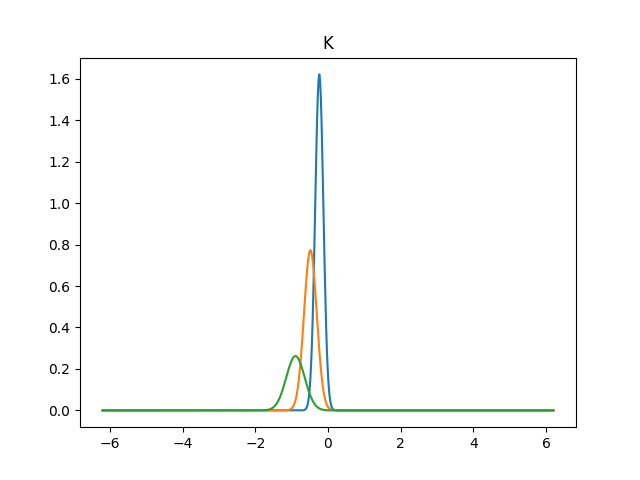

array([[0.23537974, 0.54308256, 0.22153771]])

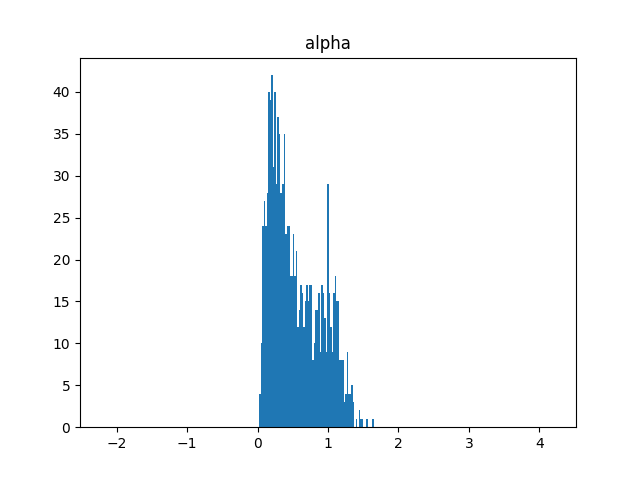

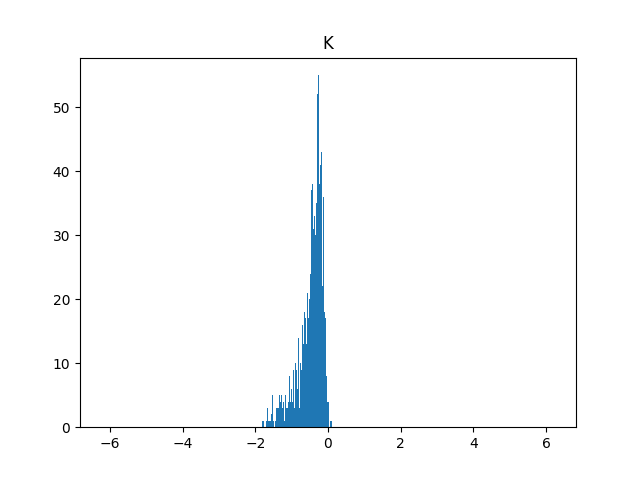

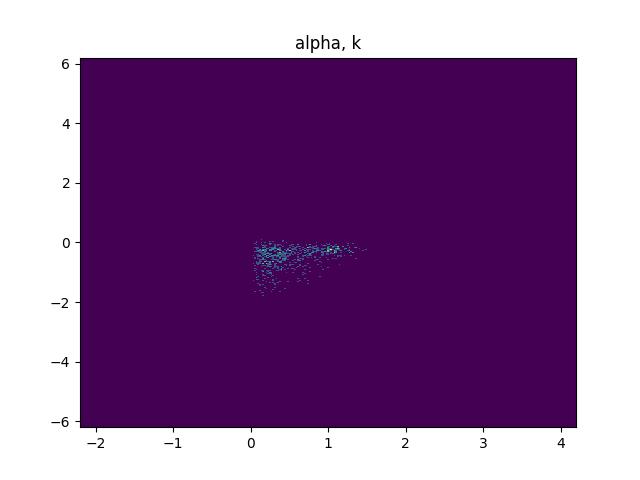

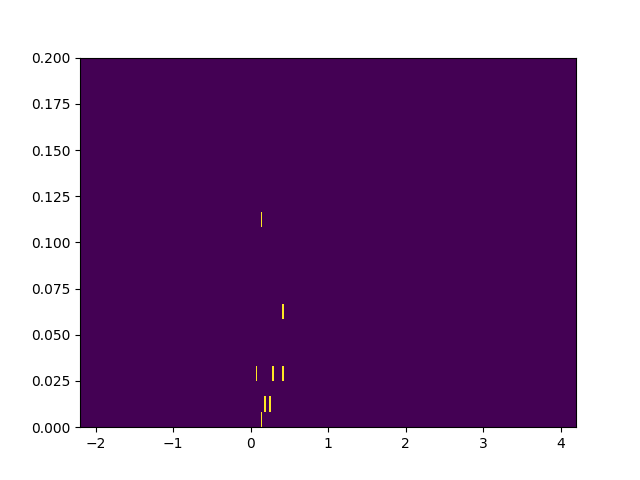

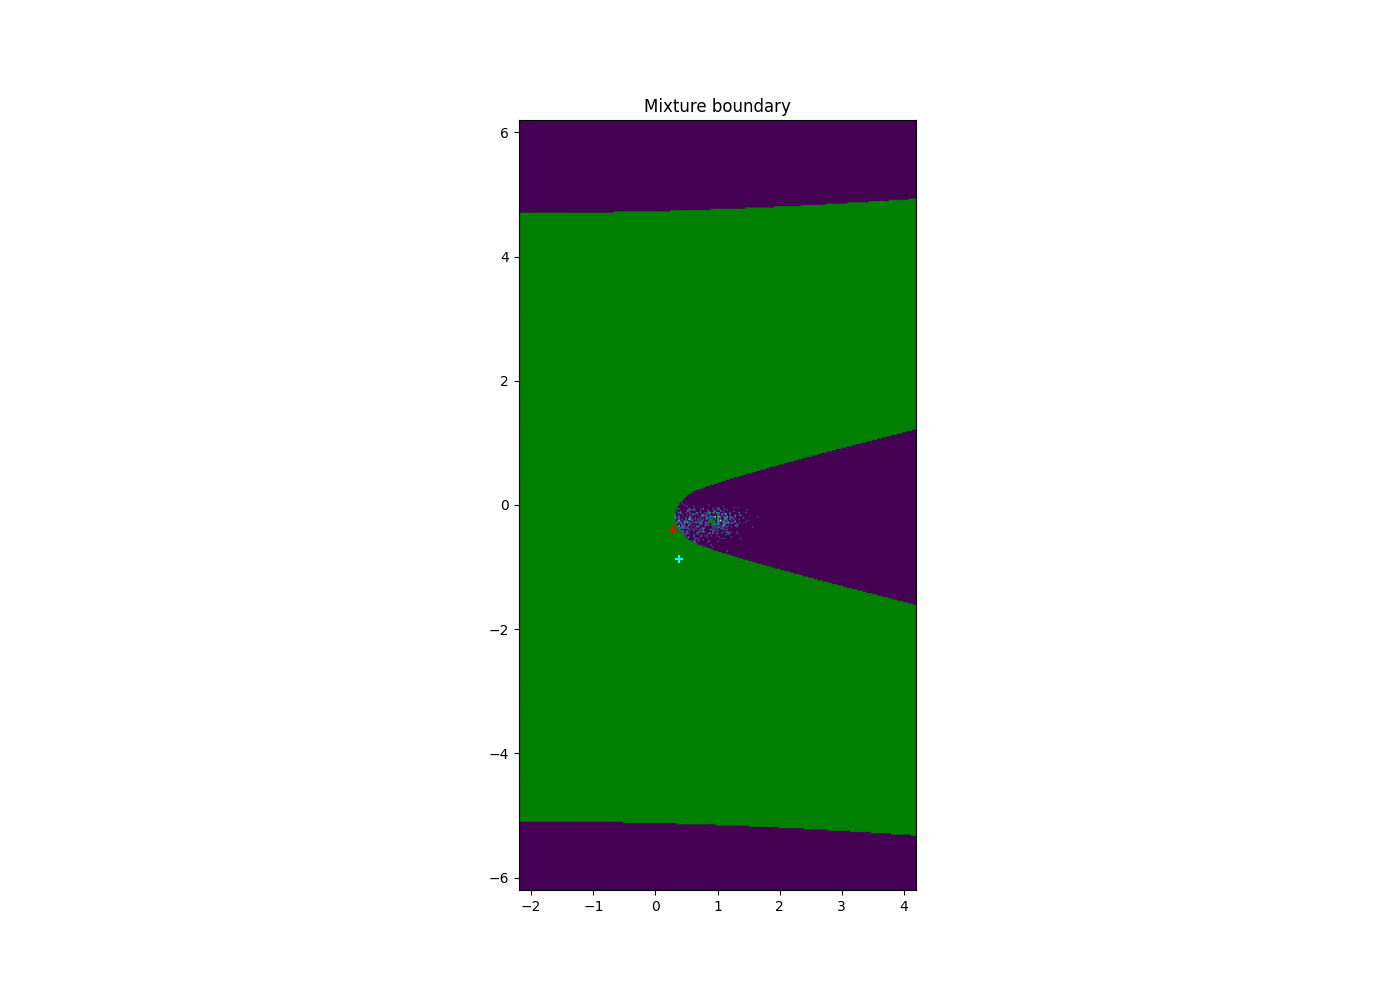

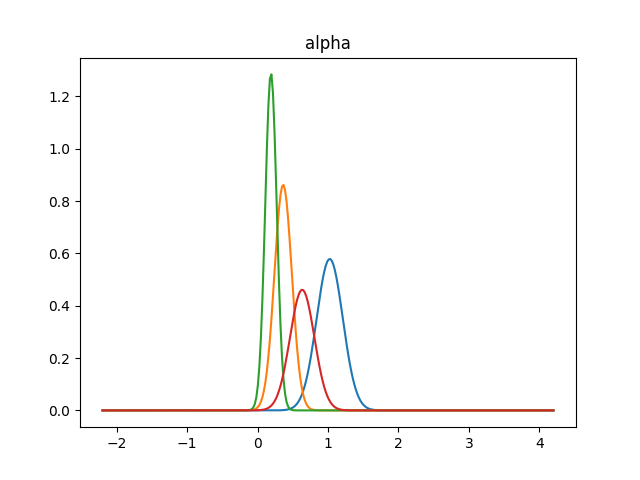

In [48]:
import scipy.stats as stats

plt.figure()
plt.title('alpha')
plt.hist(all_alphas, bins=alpha_range)
plt.figure()
plt.title('K')
plt.hist(all_ks, bins=k_range)

plt.figure()
plt.title('alpha, k')
plt.hist2d(all_alphas, all_ks, bins=[xedges, yedges])
plt.figure()
plt.hist2d(all_alphas, all_ks, bins=[xedges, np.linspace(0.0, 0.2, 25)])

plt.figure(figsize=(14, 10))
plt.title("Mixture boundary")
ZX, ZY = np.meshgrid(alpha_range, k_range)
Z = np.stack((ZX, ZY)).T.reshape(-1, 2)
ZC = cluster.predict(Z)
ZP = cluster.predict_proba(Z)

color_codes = {0:'red', 1:'green', 2:'cyan', 3:'yellow'}
selec_zone = 1
zone_90 = []
zone_90_coord = []
zone_90_color = []
for i in range(len(ZP)):
    if ZP[i][selec_zone] > 0.00 and ZP[i][selec_zone] < 0.05:
        zone_90_color.append(color_codes[selec_zone])
        zone_90_coord.append(Z[i])
zone_90_coord = np.array(zone_90_coord)
zone_90_color = np.array(zone_90_color)

plt.scatter(zone_90_coord[:,0], zone_90_coord[:,1], c=zone_90_color, s=0.7, alpha=0.9, zorder=1)
#plt.scatter(Z[:,0], Z[:,1], c=ZC, s=0.7, alpha=0.3, zorder=1)
plt.imshow(H.T, extent=(alpha_range[0], alpha_range[-1], k_range[0], k_range[-1]), origin='lower', alpha=1.0)
#plt.hist2d(all_alphas, all_ks, bins=[xedges, yedges])
for i, cluster_mean in enumerate(cluster.means_):
    plt.scatter(cluster_mean[0], cluster_mean[1], marker='+', c=color_codes[i])
    print(cluster.predict([[cluster_mean[0], cluster_mean[1]]]))

for i in range(2):
    plt.figure()
    if i ==0:
        plt.title("alpha")
    else:
        plt.title('K')
    for j in range(len(means[i])):
        mu = means[i][j]
        sigma = np.sqrt(covs[i][j])
        weight = weights[i][j]
        if i == 0:
            plt.plot(alpha_range, stats.norm.pdf(alpha_range, mu, sigma) * weight)
        else:
            plt.plot(k_range, stats.norm.pdf(k_range, mu, sigma) * weight)
plt.show()
cluster.predict_proba([[0.56, 0.0]])

In [58]:
class FixedCovMixture:
    """ The model to estimate gaussian mixture with fixed covariance matrix. """
    def __init__(self, n_components, cov, max_iter=100, random_state=None, tol=1e-10):
        self.n_components = n_components
        self.cov = cov
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol=tol

    def fit(self, X):
        # initialize the process:
        np.random.seed(self.random_state)
        n_obs, n_features = X.shape
        self.mean_ = X[np.random.choice(n_obs, size=self.n_components)]
        # make EM loop until convergence
        i = 0
        for i in range(self.max_iter):
            new_centers = self.updated_centers(X)
            if np.sum(np.abs(new_centers-self.mean_)) < self.tol:
                break
            else:
                self.mean_ = new_centers
        self.n_iter_ = i

    def updated_centers(self, X):
        """ A single iteration """
        # E-step: estimate probability of each cluster given cluster centers
        cluster_posterior = self.predict_proba(X)
        # M-step: update cluster centers as weighted average of observations
        weights = (cluster_posterior.T / cluster_posterior.sum(axis=1)).T
        new_centers = np.dot(weights, X)
        return new_centers


    def predict_proba(self, X):
        likelihood = np.stack([multivariate_normal.pdf(X, mean=center, cov=self.cov) 
                               for center in self.mean_])
        cluster_posterior = (likelihood / likelihood.sum(axis=0))
        return cluster_posterior

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0)

In [59]:
samples = np.vstack((np.zeros_like(all_alphas), all_alphas)).T

In [68]:
model = FixedCovMixture(3, cov=[[0.1,0],[0,0.2]])
model.fit(samples)
print(model.n_iter_, 'iterations')
print(model.mean_)

46 iterations
[[0.         0.84248294]
 [0.         0.84248294]
 [0.         0.84248294]]


In [70]:
# randomly initialize gmm parameters -> means, covariances & weights (strength of each gaussian)
def initialize_gmm_parameters(v_noOfVariables, k_noOfGaussDist, cov_scale=1):
    # initialize k random nos ( range 0-1 ) as weights for each gaussian in gmm
    W_gaussWeights = np.random.random(k_noOfGaussDist)
    # since the weights must sum up to 1 (constraint) we divide each weight by total sum of weights
    W_gaussWeights /= W_gaussWeights.sum() 
    
    # randomly initialize v means for each gaussian in th range 0-100
    U_gaussMeans = np.random.randint(0, 100, (k_noOfGaussDist, v_noOfVariables))
    
    # initialize k covariance matrices each (v*v) for every gaussian, use identity matrices 
    S_covMatrices = np.array([np.eye(v_noOfVariables)] * k_noOfGaussDist ) * cov_scale # generate k matrices each v*v
    
    return [W_gaussWeights, U_gaussMeans, S_covMatrices]

In [71]:
# fit the data X to gmm and the return the optimal paramters
def gmm_fit(X, k_noOfGaussDist, tol=0.1, max_iter=100):
    """Uses Expectation Maximization (EM) algorithm"""
    # look at the data
    n_noOfSamples, v_noOfVariables = X.shape
    # initialize parameters 
    W_gaussWeights, U_gaussMeans, S_covMatrices = initialize_gmm_parameters(v_noOfVariables, k_noOfGaussDist, X.std())
    ll_history = []
    ll_old = 0 # log-likelihood
    # start training
    print('Iterations: ', end='')
    for i in range(max_iter):
        print(str(i) + '.', end='')
        
        # E-STEP ->
            # Compute the probability that each data point was generated by each of the k Gaussians.
            # In other words, compute a matrix where the rows are the data points & the cols are the Gaussians, 
                # an element at row i, column j is the probability that x{i} was generated by Gaussian j.
        
        # initialize matrix E with zeros
        E = np.zeros((k_noOfGaussDist, n_noOfSamples))
        
        # for each sample compute the probability that it belongs to each of the k Gaussians
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                # first form a gaussian with the current parameters then calculate probability for sample
                E[j, i] = W_gaussWeights[j] * mvn(U_gaussMeans[j], S_covMatrices[j], allow_singular=True).pdf(X[i])
        
        # sum of probabilities for different gaussians on a sample must be one so we divide by the sum  
        E /= E.sum(0)
        
        # M-STEP ->
            # In this step, update weights, means, & covariances.
            # 1. For weights -> sum up the probability that each point was generated by Gaussian j and
                # divide by the total number of points.
            # 2. For means -> compute the mean of all points weighted by the probability of that point 
                # being generated by Gaussian j.
            # 3. For covariances -> compute the covariance of all points weighted by the probability of that point
                # being generated by Gaussian j.
            # Do each of these for each Gaussian j.
        
        # Update weights (strength of each gaussian)
        W_gaussWeights = np.zeros(k_noOfGaussDist)
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                W_gaussWeights[j] += E[j, i]
        W_gaussWeights /= n_noOfSamples

        # Update means
        U_gaussMeans = np.zeros((k_noOfGaussDist, v_noOfVariables))
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                U_gaussMeans[j] += E[j, i] * X[i]
            U_gaussMeans[j] /= E[j, :].sum()
 
        # Update covariances
        S_covMatrices = np.zeros((k_noOfGaussDist, v_noOfVariables, v_noOfVariables))
        for j in range(k_noOfGaussDist):
            for i in range(n_noOfSamples):
                ys = np.reshape(X[i] - U_gaussMeans[j], (v_noOfVariables, 1))
                S_covMatrices[j] += E[j, i] * np.dot(ys, ys.T)
            S_covMatrices[j] /= E[j, :].sum()

        # update complete log likelihoood
        # iterate till log-likelihood doesn't change upto a certain tolerance 
        ll_new = 0.0
        for i in range(n_noOfSamples):
            s = 0
            for j in range(k_noOfGaussDist):
                s += W_gaussWeights[j] * mvn(U_gaussMeans[j], S_covMatrices[j], allow_singular=True).pdf(X[i])
            ll_new += np.log(s)
#         print(f'log_likelihood: {ll_new:3.4f}; ')
        ll_history.append(ll_old)
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new        
        
    return [ll_history,W_gaussWeights.round(2), U_gaussMeans.round(2), S_covMatrices.round(2)]

In [276]:
def gauss2d(x, x_val, y_val=None):
    mu_x = x[1]
    mu_y = x[0]
    sigma_x = x[3]
    sigma_y = x[2]
    norm_factor = x[4]
    #norm_factor = 1
    if y_val is None:
        return (norm_factor * np.exp(-1/2 * (((x_val[:,:,1] - mu_x)/sigma_x)**2 + ((x_val[:,:,0] - mu_y)/sigma_y)**2)))
    else:
        print(np.sum((norm_factor * np.exp(-1/2 * (((x_val[:,:,1] - mu_x)/sigma_x)**2 + ((x_val[:,:,0] - mu_y)/sigma_y)**2))).reshape(y_val.shape) - y_val))
        return np.sum((norm_factor * np.exp(-1/2 * (((x_val[:,:,1] - mu_x)/sigma_x)**2 + ((x_val[:,:,0] - mu_y)/sigma_y)**2))).reshape(y_val.shape) - y_val)

In [148]:
def fun_rosenbrock(x):
    return np.array([10 * (x[1] - x[0]**2), (1 - x[0])])

Submit number: 2
Track: 2, Exp: 0
--- post processing ---
[0.         0.85584491]
[0.         1.10448881]
[0.         0.06116887]
[0.63354205 0.2360137  0.13044426]
nb_state:3
[0.        0.6895119]
[0.         0.68907866]
[0.         0.46691318]
[0.67057866 0.12602757 0.20339377]
nb_state:3
[-6.97350929e+02  2.39582237e+00  8.61628100e+02  5.35889827e+02
 -6.96727703e+05]


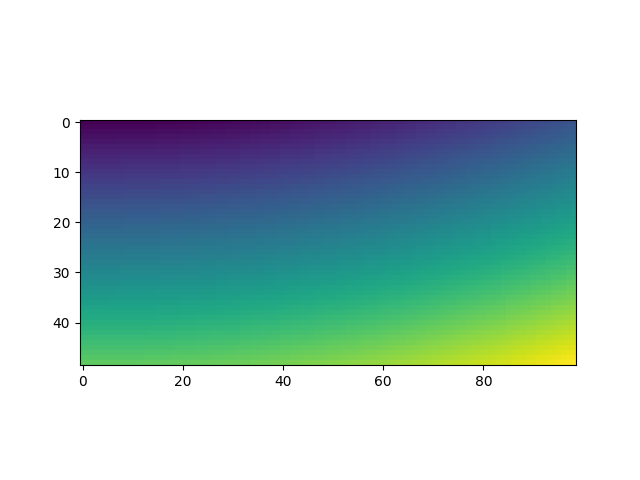

0.2212078131623194 False
0.3113980407730604 False
(1, 4851)
(1, 4851)


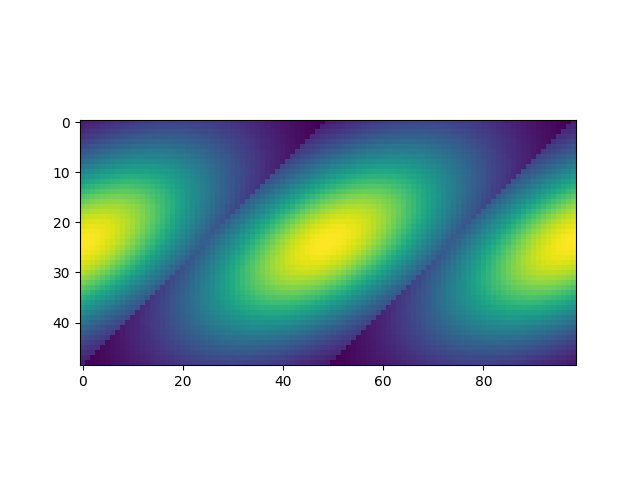

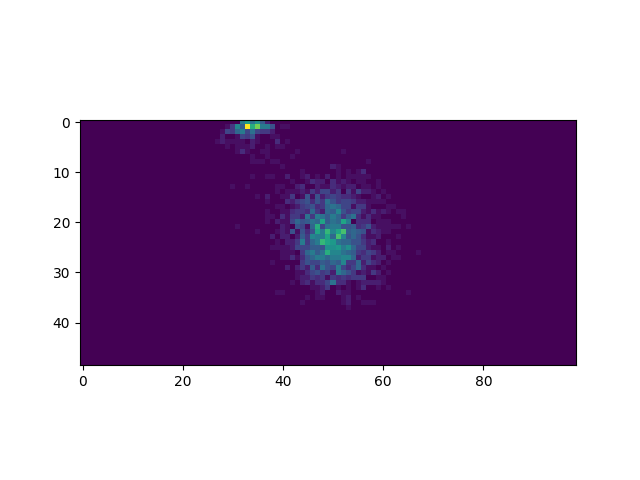

In [307]:
# Define the number of experiments and number of FOVS
print(f'Submit number: {submit_number}')
for track in [2]:
    path_track = path_results + f'track_{track}/'

    for exp in [0]:
        path_exp = path_track + f'exp_{exp}/'
        print(f'Track: {track}, Exp: {exp}')
        try:
            #loaded = np.load(f'{path_results}/old_priors_0.20_seuil/old_priors_{track}_{exp}.npz')
            loaded = np.load(f'{path_results}/priors_{track}_{exp}.npz')
            all_alphas = loaded['alphas']
            all_seg_lengths = loaded['seg_lengths']
            all_ks = loaded['all_ks']
            no_priors = False
        except:
            no_priors = True
            print(f'No priors for exp:{exp}')
            
        print('--- post processing ---')
        sampling_nb = 1000
        alpha_range = np.linspace(0.0, 2.0, 50)
        k_range = np.linspace(0.0, np.max(all_ks), 100)
        all_alphas = all_alphas[np.argwhere((all_seg_lengths > 24) & (all_seg_lengths < 256)).flatten()]
        all_ks = all_ks[np.argwhere((all_seg_lengths > 24) & (all_seg_lengths < 256)).flatten()]

        H, xedges, yedges = np.histogram2d(all_alphas, all_ks, bins=[alpha_range, k_range])
        H = H / np.max(H)


        poten_nb_states = 0
        for data, data_range in zip([all_alphas, all_ks], [alpha_range, k_range]):
            nb_states = 0
            weight_sum = 0
            
            hist = np.histogram(data, bins=data_range)
            prior_info = scipy.stats.rv_histogram(hist, density=True)
            p_ = prior_info.pdf(data_range)
            p_ = p_ / np.sum(p_)
            samples = np.random.choice(data_range, p=p_, size=5000)
            samples = np.vstack((np.zeros_like(samples), samples)).T
            bgm = BayesianGaussianMixture(n_components=3, max_iter=3000, n_init=2).fit(samples)
            
            for mean, weight in zip(bgm.means_[np.argsort(bgm.weights_)[::-1]],
                                    bgm.weights_[np.argsort(bgm.weights_)[::-1]]):
                weight_sum += weight
                nb_states += 1
                print(mean)
                if weight_sum >= 0.90:
                    break

            poten_nb_states = max(poten_nb_states, nb_states)
            print(bgm.weights_)
            print(f'nb_state:{nb_states}')

        ZX, ZY = np.meshgrid(np.arange(H.shape[0]), np.arange(H.shape[1]))
        Z = np.stack((ZX, ZY)).T
        #KK = (Z)[:-1, :-1, :]


        H = H.reshape(49, 99, 1)
        KK = Z.reshape([H.shape[0], H.shape[1], 2])

        plt.figure()
        plt.imshow(H)

        #y_vals = gauss2d([1.0, 0.6, 0.1, 0.1, 1], KK, H)
        #print(y_vals.shape)
        #plt.imshow(y_vals.T, extent=(alpha_range[0], alpha_range[-1], k_range[0], k_range[-1]), origin='lower', alpha=1.0)
        #plt.show()
        #print(y_vals)
        """
        opt_result = scipy.optimize.minimize(gauss2d,
                                                  x0=np.array([50.0, 25.0, 10.0, 10.0, 0.01]),
                                                  args=(KK, H),
                                                  jac='3-point',
                                                  )
        """
        print(opt_result.x)
        #y_vals = gauss2d(opt_result.x, KK).reshape(y_vals.shape[0], y_vals.shape[1], 1)
        plt.figure()
        plt.imshow(y_vals)
        plt.show()

        regress_imgs = H.reshape(1, H.shape[0], H.shape[1])
        pdfs, xs, ys, x_vars, y_vars, amps, rhos = image_regression(regress_imgs, np.zeros((H.shape[0], H.shape[1])),
                                                                    (H.shape[0], H.shape[1]), p0=[1.0, 25, 1.0, 25, 0., 0.01], decomp_n=1)
        
        print(pdfs.shape)
        plt.figure()
        plt.imshow(pdfs[0].reshape(H.shape))
        plt.show()


In [282]:
def quantification(imgs, window_size, amp):
    if amp == 0:
        qt_imgs = imgs.reshape(imgs.shape[0], -1, 1)
    else:
        qt_imgs = (imgs * (10**amp)).astype(np.uint32).reshape(imgs.shape[0], -1, 1)
    x = np.arange(-(window_size[0]-1)/2, (window_size[0]+1)/2)
    y = np.arange(-(window_size[1]-1)/2, (window_size[1]+1)/2)
    xv, yv = np.meshgrid(x, y, sparse=True)
    grid = np.stack(np.meshgrid(xv, yv), -1).reshape(window_size[0] * window_size[1], 2)
    return qt_imgs, grid

In [294]:
def matrix_decomp(matrix, q):
    ret_mat = []
    for x in range(0, len(matrix), q):
        ret_mat.append(matrix[x: min(x+q, len(matrix))])
    return ret_mat

In [283]:
def bi_variate_normal_pdf(xy, cov, mu, normalization=True):
    a = np.ones((cov.shape[0], xy.shape[0], xy.shape[1])) * (xy - mu)
    if normalization:
        return (np.exp((-1./2) * np.sum(a @ np.linalg.inv(cov) * a, axis=2))
                / (2 * np.pi * np.sqrt(np.linalg.det(cov).reshape(-1, 1))))
    else:
        return (np.exp((-1./2) * np.sum(a @ np.linalg.inv(cov) * a, axis=2)))

In [306]:
def image_regression(imgs, bgs, window_size, p0, decomp_n, amp=0, repeat=5):
    imgs = np.array(imgs)
    bgs = np.array(bgs)
    qt_imgs, grid = quantification(imgs, window_size, amp)
    coefs = guo_algorithm(imgs, bgs, p0=p0, window_size=window_size, repeat=repeat, decomp_n=decomp_n)
    variables, err_indices = unpack_coefs(coefs, window_size)
    if len(err_indices) > 0:
        coefs = guo_algorithm(imgs, bgs, p0=p0, window_size=window_size, repeat=repeat+1, decomp_n=decomp_n)
        variables, err_indices = unpack_coefs(coefs, window_size)
    variables = np.array(variables).T
    cov_mat = np.array([variables[:, 0], variables[:, 4] * np.sqrt(variables[:, 0]) * np.sqrt(variables[:, 2]),
                        variables[:, 4] * np.sqrt(variables[:, 0] * np.sqrt(variables[:, 2])), variables[:, 2]]
                       ).T.reshape(variables.shape[0], 2, 2)
    pdfs = bi_variate_normal_pdf(grid, cov_mat, mu=np.array([0, 0]), normalization=False)
    print(pdfs.shape)
    pdfs = variables[:, 5].reshape(-1, 1) * pdfs
    for err_i in err_indices:
        variables[err_i][0] = -100
        variables[err_i][2] = -100
    return pdfs, variables[:, 1], variables[:, 3], variables[:, 0], variables[:, 2], variables[:, 5], variables[:, 4]

In [285]:
def unpack_coefs(coefs, window_size):
    err_indices = []
    x_mu = []
    y_mu = []
    rho = coefs[:, 4] * np.sqrt(1/(4 * -abs(coefs[:, 0]) * -abs(coefs[:, 2])))
    k = 1 - rho**2
    x_var = abs(1/(-2 * coefs[:, 0] * k))
    y_var = abs(1/(-2 * coefs[:, 2] * k))
    for err_indice, (xvar_check, yvar_check, r) in enumerate(zip(x_var, y_var, rho)):
        if xvar_check < 0 or yvar_check < 0 or xvar_check > 3 * window_size[0] or yvar_check > 3 * window_size[1] or r < -1 or r > 1 or np.isnan(r):
            print(r, np.isnan(r))
            err_indices.append(err_indice)

    for i, (b, d) in enumerate(zip(coefs[:, 1], coefs[:, 3])):
        if i in err_indices:
            x_mu.extend([0])
            y_mu.extend([0])
        else:
            coef_mat = np.array([[-rho[i] * np.sqrt(y_var[i]) / np.sqrt(x_var[i]), 1.],
                                 [1., -rho[i] * np.sqrt(x_var[i]) / np.sqrt(y_var[i])]])
            ans_mat = np.array([[d * k[i] * y_var[i]], [b * k[i] * x_var[i]]])
            x_, y_, = np.linalg.lstsq(coef_mat, ans_mat, rcond=None)[0]
            x_mu.extend(x_)
            y_mu.extend(y_)
    x_mu = np.array(x_mu)
    y_mu = np.array(y_mu)
    amp = np.exp(coefs[:, 5] + (x_mu**2 / (2 * k * x_var)) + (y_mu**2 / (2 * k * y_var)) - (rho * x_mu * y_mu / (k * np.sqrt(x_var) * np.sqrt(y_var))))
    return [x_var, x_mu, y_var, y_mu, rho, amp], err_indices

In [286]:
def pack_vars(vars, len_img):
    a = -1./(2 * vars[0] * (1 - vars[4]**2))
    b = vars[1] / ((1 - vars[4]**2) * vars[0]) - (vars[4] * vars[3]) / ((1 - vars[4]**2) * np.sqrt(vars[0]) * np.sqrt(vars[2]))
    c = -1. / (2 * vars[2] * (1 - vars[4]**2))
    d = vars[3] / ((1 - vars[4]**2) * vars[2]) - (vars[4] * vars[1]) / ((1 - vars[4]**2) * np.sqrt(vars[0]) * np.sqrt(vars[2]))
    e = vars[4] / ((1 - vars[4]**2) * np.sqrt(vars[0]) * np.sqrt(vars[2]))
    f = (-(vars[1]**2)/(2*(1-vars[4]**2)*vars[0]) - (vars[3]**2)/(2*(1-vars[4]**2)*vars[2]) + (vars[4]*vars[1]*vars[3])/((1-vars[4]**2)*np.sqrt(vars[0]) * np.sqrt(vars[2])) +
         np.log(1/(2*np.pi*np.sqrt(vars[0]) * np.sqrt(vars[2])*(np.sqrt(1-vars[4]**2)))))
    return [[a, b, c, d, e, f] for _ in range(len_img)]

In [291]:
def guo_algorithm(imgs, bgs, p0=None, window_size=(7, 7), repeat=5, decomp_n=2):
    k = 0
    nb_imgs = imgs.shape[0]
    if p0 is None:
        p0 = [1.5, 0., 1.5, 0., 0., 0.5]  # x_var, x_mu, y_var, y_mu, rho, amp
    coef_vals = np.array(pack_vars(p0, nb_imgs))
    imgs = imgs.reshape(imgs.shape[0], window_size[0], window_size[1])
    ## background for each crop image needed rather than background intensity for whole image.
    imgs = np.maximum(np.zeros(imgs.shape), imgs - bgs.reshape(-1, window_size[0], window_size[1])) + 1e-2
    yk_2 = imgs.astype(np.float64).copy()
    x_grid = (np.array([list(np.arange(-int(window_size[0]/2), int((window_size[0]/2) + 1), 1))] * window_size[1])
              .reshape(-1, window_size[0], window_size[1]))
    y_grid = (np.array([[y] * window_size[0] for y in range(-int(window_size[1]/2), int((window_size[1]/2) + 1), 1)])
              .reshape(-1, window_size[0], window_size[1]))
    while k < repeat:
        if k != 0:
            yk_2 = np.exp(coef_vals[:, 0].reshape(-1, 1, 1) * x_grid**2 + coef_vals[:, 1].reshape(-1, 1, 1) * x_grid +
                          coef_vals[:, 2].reshape(-1, 1, 1) * y_grid**2 + coef_vals[:, 3].reshape(-1, 1, 1) * y_grid +
                          coef_vals[:, 4].reshape(-1, 1, 1) * x_grid * y_grid + coef_vals[:, 5].reshape(-1, 1, 1))
        yk_2 *= yk_2
        coef1 = yk_2 * x_grid**4
        coef2 = yk_2 * x_grid**3
        coef3 = yk_2 * x_grid**2 * y_grid**2
        coef4 = yk_2 * x_grid**2 * y_grid
        coef5 = yk_2 * x_grid**3 * y_grid
        coef6 = yk_2 * x_grid**2
        coef7 = yk_2 * x_grid * y_grid**2
        coef8 = yk_2 * x_grid * y_grid
        coef9 = yk_2 * x_grid
        coef10 = yk_2 * y_grid**4
        coef11 = yk_2 * y_grid**3
        coef12 = yk_2 * x_grid * y_grid**3
        coef13 = yk_2 * y_grid**2
        coef14 = yk_2 * y_grid
        coef15 = yk_2
        coef_matrix = np.sum(
            np.array(
                [[coef1, coef2, coef3, coef4, coef5, coef6],
                 [coef2, coef6, coef7, coef8, coef4, coef9],
                 [coef3, coef7, coef10, coef11, coef12, coef13],
                 [coef4, coef8, coef11, coef13, coef7, coef14],
                 [coef5, coef4, coef12, coef7, coef3, coef8],
                 [coef6, coef9, coef13, coef14, coef8, coef15]]
            ), axis=(3, 4)).transpose(2, 0, 1)
        ans1 = x_grid ** 2 * yk_2 * np.log(imgs)
        ans2 = x_grid * yk_2 * np.log(imgs)
        ans3 = y_grid ** 2 * yk_2 * np.log(imgs)
        ans4 = y_grid * yk_2 * np.log(imgs)
        ans5 = x_grid * y_grid * yk_2 * np.log(imgs)
        ans6 = yk_2 * np.log(imgs)
        ans_matrix = np.sum(
            np.array(
                [[ans1], [ans2], [ans3], [ans4], [ans5], [ans6]]
            ), axis=(3, 4), dtype=np.float64).transpose(2, 0, 1)
        coef_matrix = matrix_decomp(coef_matrix, decomp_n)
        ans_matrix = matrix_decomp(ans_matrix, decomp_n)
        decomp_coef_vals = matrix_decomp(coef_vals, decomp_n)
        x_matrix = []
        for (a_mats, b_mats, coef_val) in zip(coef_matrix, ans_matrix, decomp_coef_vals):
            a_mat = np.zeros((a_mats.shape[0] * a_mats.shape[1], a_mats.shape[0] * a_mats.shape[2]))
            for x, vals in zip(range(0, a_mat.shape[0], 6), a_mats):
                a_mat[x:x+6, x:x+6] = vals
            b_mat = b_mats.flatten().reshape(-1, 1)
            x_matrix.extend(np.linalg.lstsq(a_mat, b_mat, rcond=None)[0])
            #x_matrix.extend(gauss_seidel(a_mat, b_mat, p0=coef_val.ravel(), iter=200))
        x_matrix = np.array(x_matrix).reshape(-1, 6)
        if np.allclose(coef_vals, x_matrix, rtol=1e-7):
            break
        coef_vals = x_matrix
        k += 1
    return coef_vals

In [ ]:
# Define the number of experiments and number of FOVS
print(f'Submit number: {submit_number}')
for track in [2]:
    path_track = path_results + f'track_{track}/'

    for exp in [0]:
        path_exp = path_track + f'exp_{exp}/'
        print(f'Track: {track}, Exp: {exp}')
        try:
            #loaded = np.load(f'{path_results}/old_priors_0.20_seuil/old_priors_{track}_{exp}.npz')
            loaded = np.load(f'{path_results}/priors_{track}_{exp}.npz')
            all_alphas = loaded['alphas']
            all_seg_lengths = loaded['seg_lengths']
            all_ks = loaded['all_ks']
            no_priors = False
        except:
            no_priors = True
            print(f'No priors for exp:{exp}')
            
        print('--- post processing ---')
        sampling_nb = 1000
        alpha_range = np.linspace(-0.2, 2.2, 100)
        k_range = np.linspace(-0.2, np.max(all_ks), 100)
        all_alphas = all_alphas[np.argwhere((all_seg_lengths > 32) & (all_seg_lengths < 256)).flatten()]
        all_ks = all_ks[np.argwhere((all_seg_lengths > 32) & (all_seg_lengths < 256)).flatten()]
        print(all_alphas.shape)
        print(all_ks.shape)
        print(np.argwhere(all_seg_lengths > 64).shape)

        H, xedges, yedges = np.histogram2d(all_alphas, all_ks, bins=[alpha_range, k_range])
        H = H / np.sum(H)
        poten_nb_states = 1
        for data, data_range in zip([all_alphas, all_ks], [alpha_range, k_range]):
            hist = np.histogram(data, bins=data_range)
            prior_info = scipy.stats.rv_histogram(hist, density=True)
            p_ = prior_info.pdf(data_range)
            p_ = p_ / np.sum(p_)
            samples = np.random.choice(data_range, p=p_, size=3000)
            samples = np.vstack((np.zeros_like(samples), samples)).T
            bgm = BayesianGaussianMixture(n_components=4, max_iter=1000).fit(samples)
            popts = []
            pcovs = []
            for bgm_mean in bgm.means_[:, 1]:
                popt, pcov = scipy.optimize.curve_fit(gauss1d, data_range,
                                                      prior_info.pdf(data_range),
                                                      p0=[bgm_mean, 0.1, 1])
                if len(popts) == 0:
                    popts.append(popt)
                    pcovs.append(pcov)
                else:
                    flag = 1
                    for comp_popt in popts:
                        if not np.allclose(comp_popt, popt, rtol=1e-1):
                            flag *= 1
                        else:
                            flag *= 0
                    if flag == 1:
                        popts.append(popt)
                        pcovs.append(pcov)
            popts = np.array(popts)
            pcovs = np.array(pcovs)
            poten_nb_states = max(poten_nb_states, len(popts))
            print(len(popts))
            print(popts)
            print(bgm.n_features_in_)
            print(bgm.means_)
            print(bgm.weights_)
            
        print('Number of clusters: ', poten_nb_states)
        cluster = GaussianMixture(n_components=poten_nb_states, max_iter=10, n_init=10,
                                  covariance_type='diag').fit(np.vstack((all_alphas, all_ks)).T)
        
        print('Cluster centers: ', cluster.means_)

        for fov in range(N_FOVS):
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = np.sort(df.traj_idx.unique())
            submission_file = path_exp + f'fov_{fov}.txt'
            with open(submission_file, 'w') as f:
                # Loop over each index
                for idx in traj_idx:
                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]

                    cps, alphas, ks, _ = exhaustive_cps_search(x, y, WIN_WIDTHS,
                                                               EXT_WIDTH,
                                                               search_seuil=0.25,
                                                               cluster=cluster,
                                                               popts=popts)

                    prediction_traj = [idx.astype(int)]
                    for k, alpha, state, cp in zip(ks, alphas, [99999999] * len(cps), cps[1:]):
                        prediction_traj.append(k)
                        prediction_traj.append(alpha)
                        prediction_traj.append(state)
                        prediction_traj.append(cp)

                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')


In [ ]:
# Generate random independent variable
x = np.random.randn(300)

# Generate random noise for each dependent variable
noise = np.random.randn(300)

# Generate dependent variables based on the independent variable and noise
y = 2 * x + noise

In [ ]:
def p_x_given_y(x, y):
    # Specify the parameters of the conditional distribution
    # You can use any appropriate distribution based on your problem
    mean_x = np.mean(x)
    var_x = np.var(x)
    print(var_x)
    precision_x = 1 / var_x
    
    # Sample from the conditional distribution
    sampled_x = np.random.normal((np.mean(y) * precision_x) / (len(y) * precision_x + 1), np.sqrt(1 / (len(y) * precision_x + 1)))
    
    return sampled_x

# Conditional distribution of each dependent variable given the independent variable
def p_y_given_x(x, y):
    # Specify the parameters of the conditional distribution
    # You can use any appropriate distribution based on your problem
    mean_y = np.mean(y)
    var_y = np.var(y)
    print(var_y)
    precision_y = 1 / var_y
    
    # Sample from the conditional distribution for each dependent variable
    sampled_y = np.random.normal(mean_y + precision_y * (y - 2 * x), np.sqrt(1 / (len(y) * precision_y + 1)))
    
    return sampled_y

In [ ]:
# Initialize variables
num_iterations = 1000
samples_x = np.zeros(num_iterations)
samples_y = np.zeros((num_iterations, len(y)))

# Initialize starting values for x and y
current_x = np.random.randn()
current_y = np.random.randn(len(y))

# Perform Gibbs sampling
for i in range(num_iterations):
    # Sample x given y
    current_x = p_x_given_y(current_x, current_y)
    samples_x[i] = current_x
    
    # Sample y given x
    current_y = p_y_given_x(current_x, current_y)
    samples_y[i, :] = current_y

In [ ]:
# Print mean and standard deviation of the samples
print("Mean of x: ", np.mean(samples_x))
print("Standard deviation of x: ", np.std(samples_x))
print("Mean of y: ", np.mean(samples_y, axis=0))
print("Standard deviation of y: ", np.std(samples_y, axis=0))

# Plot the samples
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(samples_x)
plt.xlabel('Iteration')
plt.ylabel('x')
plt.title('Gibbs Sampling - Independent Variable')

plt.subplot(2, 1, 2)
for i in range(len(y)):
    plt.plot(samples_y[:, i])
plt.xlabel('Iteration')
plt.ylabel('y')
plt.title('Gibbs Sampling - Dependent Variables')

plt.tight_layout()
plt.show()